#  FINM 33150 - Regression Analysis and Quantitative Trading Strategies
## Homework 4 : Carry Trade
## Suraj Kaul (skaul) - UCID 12214950
## 5/01/2019

###  Importing the Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import quandl
import functools
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
plt.style.use('seaborn')

### Function to Fetch data from quandl

In [2]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities,sdate,edate):
    qdata = quandl.get(list(my_securities), returns="pandas",authtoken='MgKeNNH7rTeBnh4t1667',start_date=sdate, end_date=edate)
    return qdata

In [3]:
sdate,edate="2015-01-01","2019-04-15"

In [4]:
data=fetch_quandl(("YC/PAK5Y","YC/IDN5Y","YC/ROU5Y","YC/USA5Y"),sdate,edate)/100
data.to_excel("Quandl_data.xlsx")
data=data.interpolate(axis = 0, method = 'index')

### Plotting the 5Y curves for various countries
    This helps us visualize the difference in rates, for a carry trade we borrow in a currency with low interest rates and lend in a currency with higher interest rate.
    We later in code, require a difference of atleast 50bps to trade.

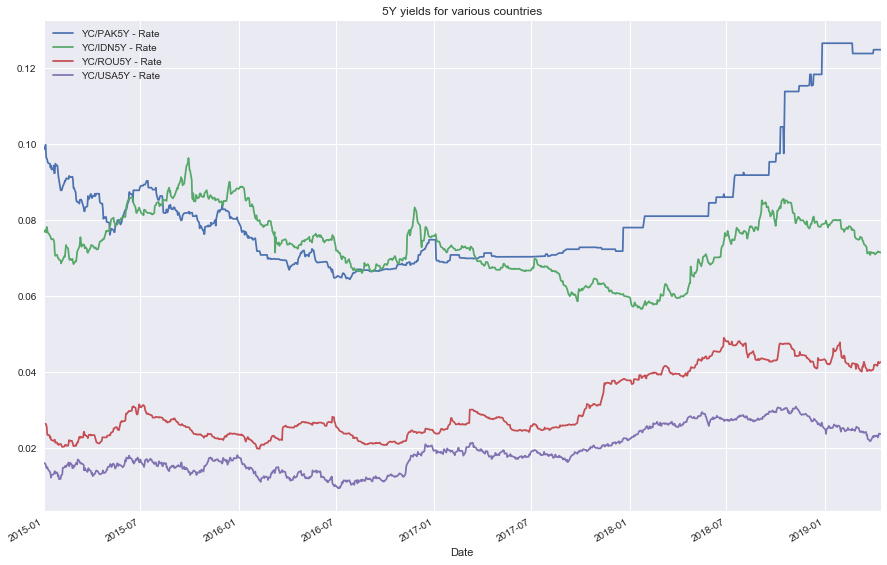

In [5]:
data.plot(figsize =(15,10))
plt.legend(loc='upper left')
plt.title("5Y yields for various countries")
plt.grid(True)
plt.show()

###  data_fetch(country=ROU/PAK/IDN/CHN)
    For getting data to the carry_trade function.
    For all currencies expect ROU and USD we had good data starting 2015, and we have used data since 2012 for ROU.
    

In [6]:
sdate,edate="2015-01-01","2019-04-15"
fx=fetch_quandl(("CUR/PKR",),sdate,edate)
fx.to_excel("CUR_PKR.xlsx")
lend=fetch_quandl(("YC/PAK",),sdate,edate)/100
lend.to_excel("YC_PAK.xlsx")

fx=fetch_quandl(("CUR/IDR",),sdate,edate)
fx.to_excel("CUR_IDR.xlsx")
lend=fetch_quandl(("YC/IDN",),sdate,edate)/100
lend.to_excel("YC_IDN.xlsx")

fx=fetch_quandl(("CUR/RON",),sdate,edate)
fx.to_excel("CUR_RON.xlsx")
lend=fetch_quandl(("YC/ROU",),sdate,edate)/100
lend.to_excel("YC_ROU.xlsx")

fx=fetch_quandl(("CUR/CNY",),sdate,edate)
fx.to_excel("CUR_CNY.xlsx")
lend=fetch_quandl(("YC/CHN",),sdate,edate)/100
lend.to_excel("YC_CHN.xlsx")

borrow=fetch_quandl(("YC/USA",),sdate,edate)/100    
borrow.to_excel("YC_USA.xlsx")
libor=fetch_quandl(("FRED/DFF",),sdate,edate)/100
libor.to_excel("FRED_DFF.xlsx")

In [6]:
def data_fetch(country):
    if country=='PAK':
        sdate,edate="2015-01-01","2019-04-15"
        fx=fetch_quandl(("CUR/PKR",),sdate,edate)
        lend=fetch_quandl(("YC/PAK",),sdate,edate)/100
        lend=lend.interpolate(axis = 0, method = 'index').iloc[:,:5].resample('W-WED').last().fillna(method="ffill")
        lend.columns=[3/12,6/12,1,3,5]
    if country=='IDN':
        sdate,edate="2015-01-01","2019-04-15"
        fx=fetch_quandl(("CUR/IDR",),sdate,edate)
        lend=fetch_quandl(("YC/IDN",),sdate,edate)/100
        lend=lend.interpolate(axis = 0, method = 'index').iloc[:,:5].resample('W-WED').last().fillna(method="ffill")
        lend.columns=[1,2,3,4,5]
    if country=='ROU':
        sdate,edate="2012-01-01","2019-04-15"
        fx=fetch_quandl(("CUR/RON",),sdate,edate)
        lend=fetch_quandl(("YC/ROU",),sdate,edate)/100
        lend=lend.interpolate(axis = 0, method = 'index').iloc[:,:4].resample('W-WED').last().fillna(method="ffill")
        lend.columns=[6/12,1,3,5]        
    if country=='CHN':
        sdate,edate="2015-01-01","2019-04-15"
        fx=fetch_quandl(("CUR/CNY",),sdate,edate)
        lend=fetch_quandl(("YC/CHN",),sdate,edate)/100
        lend=lend.interpolate(axis = 0, method = 'index').iloc[:,:5].resample('W-WED').last().fillna(method="ffill")
        lend.columns=[1,2,3,4,5]

    fx=fx.interpolate(axis = 0, method = 'index').resample('W-WED').last()
    borrow=fetch_quandl(("YC/USA",),sdate,edate)/100
    borrow=borrow.interpolate(axis = 0, method = 'index').iloc[:,:7].resample('W-WED').last().fillna(method="ffill")
    borrow.columns=[1/12,3/12,6/12,1,2,3,5]
    
    libor=fetch_quandl(("FRED/DFF",),sdate,edate)/100
    libor=libor.interpolate(axis = 0, method = 'index').resample('W-WED').last().fillna(method="ffill")
    
    return fx,lend,borrow,libor

In [7]:
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor,0, step=-0.5)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values[:,0]) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p

In [8]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():            
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                coupon_quarter = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_quarter*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_quarter))/tenor
    return zcb_rates


## carry_trade(cur=ROU/PAK/IDN/CHN)
    Total Capital = USD 10M (5x Leverage)
    Borrowed Capital = USD 8M
    Self Capital/Self Funded= USD 2M
    We always assume the borrow currency to be USD, (although we can use ROU as well), and lending currency to be one of the four (ROU/PAK/IDR/CHN).


## PNL = Bond PNL + FX PNL + Interest (Borrow CCY)
    Here we have broken down the PNL into three categories to see the effect of each component individually.
    
   1. Bond PNL : PNL we make on the M2M of the Lending Currency Bonds
   2. Interest : Borrowed Capital * (3M libor + 50 Bps)
   3. FX PNL : PNL we make due to FX rates movement, 
   __(it's bad for us when they rise, as my local currency is worth less now when I'm converting back to USD)__
 
  

### Column Names

    1. 'full_bond_price' : bond price with 5Y tenor and priced using same date zcb and 5y coupon
    2. '1w_bond_price' : bond price of bond 1w later, priced using same date zcb but previous week 5y coupon rate
    3. 'borrow_5y': 5Y borrow rate of the borrow currency (USD)
    4. 'lend_5y' : 5Y lend rate of the lending currency (Foreign), higher than borrow 5Y above
    5. 'borrow_3m' : 3M borrow rate of USD, we are charged 3M + 50 bps as the interest
    6. 'fx' : FX rate
    7. 'local_currency' : Local currency equivalent of 10M USD on given day
    8. 'bond_bought' : Units of Bonds bought = local_currency / bond price
    9. 'local_recv_1w' : local currency recieved one week later after selling the bond
    10. 'USD_recv' : converting local_recv_1w into USD
    11. 'Bond_Pnl' : M2M/PNL on the Bond
    12. 'borrow_interest' : Interest charged on the borrow currency 3M + 50 bps (-ve number)
    13. 'Pnl' : Overall PNL
    14. 'Return' : PNL/Self Capital (cause 5x leverage)
    15. 'running_sharpe' : Sharpe Ratio for last 52 weeks
    16. 'running_sortino' : Sortino Ratio for last 52 weeks
    17. 'fx_held_const' : fx moved by one unit, so no change day on day fx(1)=fx_held_const(2) i.e. buy and sell bonds at same fx rates
    18. 'USD_recv_no_fx_change' : converting local_recv_1w into USD assuming no change in FX rates
    19. 'Bond_Pnl_no_fx_change' : Bond PNL assuming no change in FX rates
    20. 'fx_pnl' : PNL - Interest - Bond_Pnl_no_fx_change

In [9]:
def carry_trade(cur):
    
    fx ,df_lend ,df_borrow ,fed_3m = data_fetch(cur)    
    
    self_capital=2.*np.power(10,6)
    borrowed_capital=8.*np.power(10,6)
    total_capital=self_capital+borrowed_capital
    
    zero_curve=compute_zcb_curve(df_lend.T)
    df=df_borrow[[]]
    df["full_bond_price"]=0.0
    df["1w_bond_price"]=0.0    
    for i in range(0,len(zero_curve.T)):
        df.iat[i,0]=bond_price(zero_curve.iloc[:,i:i+1],df_lend.iloc[i:i+1,:][5],5.)
        if not i==len(zero_curve.T)-1:
            df.iat[i+1,1]=bond_price(zero_curve.iloc[:,i+1:i+2],df_lend.iloc[i:i+1,:][5],5.-1/52)
    
    df['borrow_5y'] =  df_borrow[5]       
    df['lend_5y'] = df_lend[5]
    df['borrow_3m'] = fed_3m
    df['fx'] = fx
    #
     
    df['local_currency'] = total_capital * df['fx']
    df['bond_bought'] = (df['local_currency']/df["full_bond_price"]).fillna(0.)
    df['bond_bought'][-1] = 0.
    df['bond_bought'] = np.where(df['lend_5y']-df['borrow_5y']>0.005,df['bond_bought'],0.)
    df['local_recv_1w'] = (df['bond_bought'].shift(1) * df['1w_bond_price']).fillna(0.)
    df['USD_recv'] = df['local_recv_1w'] / df['fx']    
    df['Bond_Pnl'] = df['USD_recv'] - np.where(df['bond_bought'].shift(1)>0.,total_capital,0.)
    df['Bond_Pnl'][0]=0.
    df['borrow_interest'] = -1 *np.where(df['bond_bought'].shift(1)>0.,borrowed_capital,0.)\
                    *((df['borrow_3m'].shift(1).fillna(0)+0.005)/52)
    df['borrow_interest'][0] = 0.
    df['Pnl']= df['Bond_Pnl'] + df['borrow_interest']
    
    #return metrics
    df['Return'] = df['Pnl'] / self_capital
    #df['Return_cum'] = df['Return'].cumsum()
    df['running_sharpe'] = df['Return'].rolling(52).mean()/df['Return'].rolling(52).std()
    df['running_sortino'] = df['Return'].rolling(52).mean()/df['Return'].\
            rolling(52).apply(lambda x: np.std([i for i in x if i < 0],ddof=1))
    
    #columns to calculate the breakdown of pnl
    df['fx_held_const']=df['fx'].shift(1).fillna(0)
    df['USD_recv_no_fx_change']=df['local_recv_1w'] / df['fx_held_const']
    df['Bond_Pnl_no_fx_change'] = df['USD_recv_no_fx_change'] - np.where(df['bond_bought'].shift(1)>0.,total_capital,0.)
    df['Bond_Pnl_no_fx_change'][0]=0.
    df['fx_pnl']= df['Bond_Pnl'] - df['Bond_Pnl_no_fx_change']      
     
       #calling the graphing function 
    graph_metrics(df,cur)
    
    #return df

In [10]:
def graph_metrics(df1,cur):
    df=df1.copy()
    if cur=="ROU":
        sdate,edate="2012-01-01","2019-04-15"
    else:
        sdate,edate="2015-01-01","2019-04-15"
    #pulling spx and vix using pandas-webreader
    vix = web.DataReader('^VIX', 'yahoo', start=sdate, end=edate)
    vix=vix.resample('W-WED').last().fillna(method="ffill")["Adj Close"]
    
    spx = web.DataReader('^GSPC', 'yahoo',start=sdate, end=edate)
    spx=spx.resample('W-WED').last().fillna(method="ffill")["Adj Close"]
    spx_arr=spx/spx[0]-1
    
    plt.figure(figsize=(15,5))
    #plt.subplots(figsize=(5,5))
    plt.subplot(121)
    plt.title("Distribution of weekly returns")
    plt.hist(df['Return'],bins=20)
    plt.grid(linestyle='--')
    plt.xlabel("Weekly Return")
    plt.ylabel("Count")
    #plt.subplots(figsize=(10,5))
    plt.subplot(122)
    plt.plot(df.index,df['Return'],label='Weekly Return')
    plt.grid(True)
    plt.title("Weekly return for Carry Trade %s/USD pair"%cur)
    plt.xlabel("Time")
    plt.ylabel("Weekly Return")
    
    plt.legend()
    plt.show()
    plt.close()
    print("\n")
    print("Return description :")
    print(df['Return'].describe())
    print("Return Kurtosis is :%.2f"%df['Return'].kurtosis(),"\n\n")
    
    plt.figure(figsize=(15,35))
    plt.subplots(figsize=(15,15))
    plt.subplot(311)
    plt.plot(df.index,df['Pnl'].cumsum()/np.power(10.,6),label="Cummulative $ Pnl")
    plt.plot(df.index,df['fx_pnl'].cumsum()/np.power(10.,6),label="FX PNL",linestyle="--")
    plt.plot(df.index,df['Bond_Pnl_no_fx_change'].cumsum()/np.power(10.,6),label="Bond Pnl",linestyle="--")
    plt.plot(df.index,df['borrow_interest'].cumsum()/np.power(10.,6),label="Interest",linestyle="--")
    plt.title("Breakdown of Cummulative $%.2f M Pnl"%(df['Pnl'].cumsum()[-1]/pow(10.,6)))
    plt.xlabel("Time")
    plt.ylabel("$ PNL")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.subplots(figsize=(15,10))
    plt.subplot(312)
    plt.plot(df.index,df["fx"],label='USD/%s'%cur)
    plt.title("FX rate movement")
    plt.xlabel("Time")
    plt.ylabel("FX Rate")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.subplots(figsize=(15,10))
    plt.subplot(313)
    plt.plot(df.index,df["borrow_5y"]+0.005,label='USD 5Y + 50bps',linestyle=":")
    plt.title("5Y Yields/Libor Curves")
    plt.plot(df.index,df["lend_5y"]-df["borrow_5y"],label="5Y Spread")
    plt.plot(df.index,df["lend_5y"],label='%s 5Y'%cur,linestyle=":")
    plt.plot(df.index,df['borrow_3m']+0.005,label='Libor 3M + 50bps')
    plt.xlabel("Time")
    plt.ylabel("Interest Rates")
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    
    plt.figure(figsize=(15,5))
    plt.title("1Y running Risk Metrics")
    plt.plot(df.index,df['running_sharpe'],label="1Y running sharpe")
    plt.plot(df.index,df['running_sortino'],label="1Y running sortino")
    plt.xlabel("Time")
    plt.ylabel("Ratios(Sharpe/Sortino)")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    
    fig, ax =plt.subplots(figsize=(15,4))
    ax2=ax.twinx()
    ax.plot(df.index,df['Return'].cumsum(),label="Cummulative weekly Return")
    #calculating cummulative spx return similar to return above (simple addition instead of product)
    ax.plot(spx_arr,label="SPX Return",linestyle=":")
    
    ax.set_ylabel("Weekly Return")
    ax2.plot(df.index,vix,label="VIX",linestyle=":",color="purple")
    ax2.set_ylabel("VIX Level")
    plt.title("Pnl Movement with VIX and SPX")
    plt.xlabel("Time")
    ax2.legend(loc="upper right")
    ax.legend(loc="upper left")
    plt.grid(True)
    plt.show()
    print("=========================================================================================================")
    print("Correlation between Weekly Pnl and it's Components")
    print(df[['Pnl','fx_pnl','Bond_Pnl_no_fx_change',"borrow_interest"]].corr().iloc[0:1,1:3],"\n\n")
    
    

##  Doing USD/PAK Carry Trade

###    Analysis

    1. We see overall Pnl is -ve, that is specifically due to the recent currency devaluation of Pakistani Rupee, otherwise will 2018 YE we have an overall +ve Profit (~3M USD end 2017) .

    2. Return Distribution : We see a high value of distribution around 0, the left tail is fatter than the one on the right (expected), the median is >0 (more distribution to the right than left). High Return Kurtosis = 10 (expected)

    3. Cummulative Pnl : PNL is highly sensitive to the FX rates, esp since start of 2018 we see FX PNL and Overall PNL move in tandem. Although we expect the cummulative bond prices/Pnl to generally keep rising, we see midway of 2018-07 and 2019 a dip in line with the depreciation of the currency.

    4. Yield Curves : The yield spread is generally a leading indicator for FX movements[1], here although we don't see it as a leading indicator we do see FX and yield spread moving in the same direction.

    5. VIX and SPX: We see during the last quarter of 2018 when VIX spiked, the overall stratergy lost a lot of money (-ve correlation to fear indicator). 

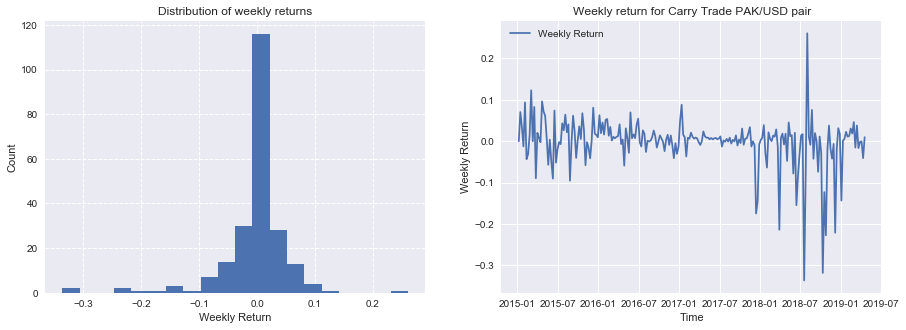



Return description :
count    224.000000
mean      -0.001902
std        0.059466
min       -0.336083
25%       -0.009566
50%        0.006520
75%        0.018568
max        0.260640
Name: Return, dtype: float64
Return Kurtosis is :10.91 




<Figure size 1080x2520 with 0 Axes>

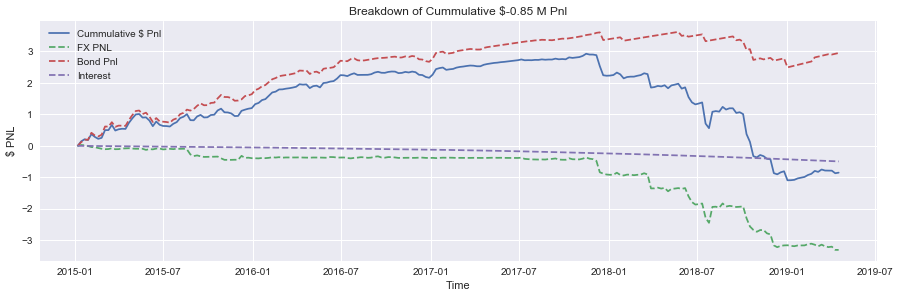

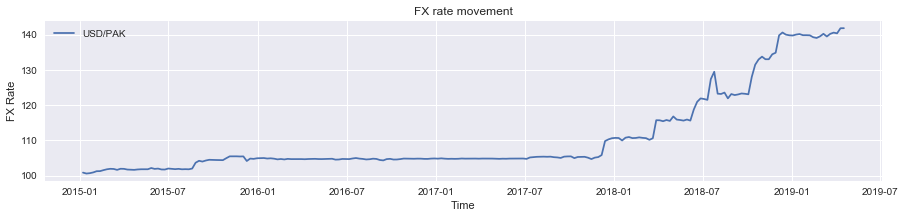

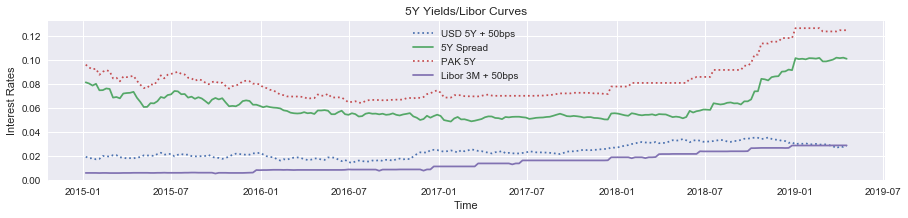

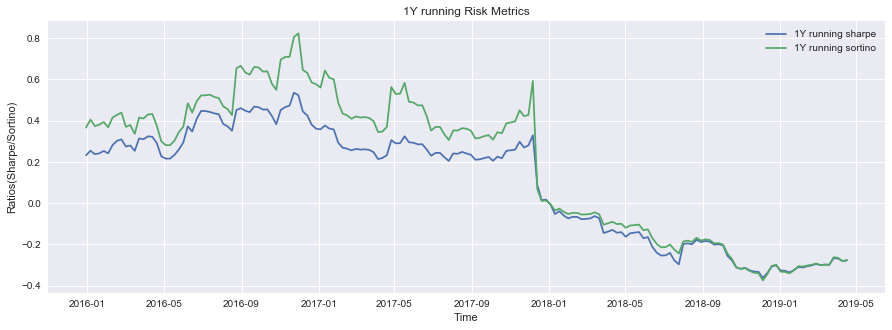

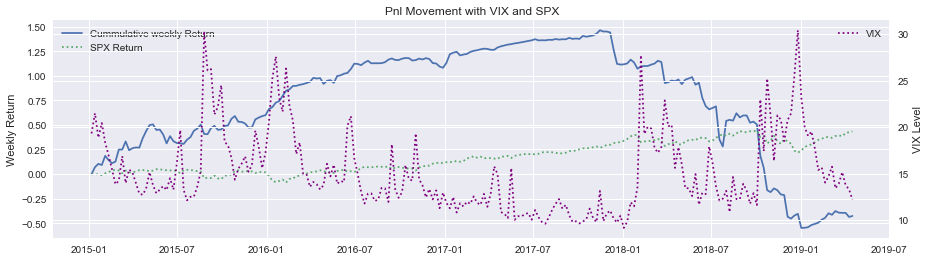

Correlation between Weekly Pnl and it's Components
       fx_pnl  Bond_Pnl_no_fx_change
Pnl  0.813369               0.756966 




In [11]:
df=carry_trade(cur="PAK")

##  Doing USD/ROU Carry Trade

###    Analysis

    1. The overall PNL is +2.4M USD over 7+ years, majority of it was made during mid 2012 to mid 2014 when FX rates were reducing a little, thus didn't really affect PNL much, and we were able to make PNL of the Bond in Lending Currency.

    2. Return Distribution : We see a high value of distribution around 0, both tails look similar(-q1=q3). The median is >0 (more distribution to the right than left). Low Return Kurtosis = 1 (less than normal, unexpected)

    3. Cummulative Pnl : Here we again see PNL being highly sensitive to rates, initially in period 2012-2014 we see falling FX rates, thus increasing PNL and in mid 2014 to early 2015 we see a sharp increase in FX movement against us thus making us Losses.

    4. Yield Curves : Here we again see the 5Y spread move along with FX, both as it falls 2012-2014

    5. VIX and SPX: We see a -ve correlation during late 2014, when VIX spike and the trade started losing money.  We also see during the last quarter of 2018 when VIX spiked, the overall stratergy lost some amount of money, not as much as the previous Pair
    
    6. One interesting thing we see if the Weekly PNL is much more correlated to the weekly FX PNL than weekly Bond PNL. 

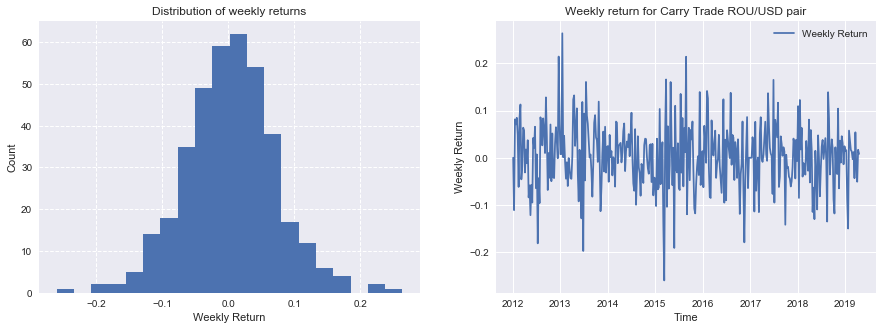



Return description :
count    381.000000
mean       0.003136
std        0.069187
min       -0.259876
25%       -0.042646
50%        0.003962
75%        0.043594
max        0.263703
Name: Return, dtype: float64
Return Kurtosis is :0.99 




<Figure size 1080x2520 with 0 Axes>

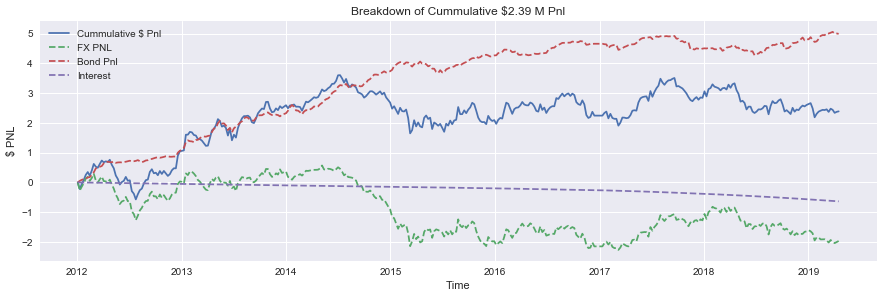

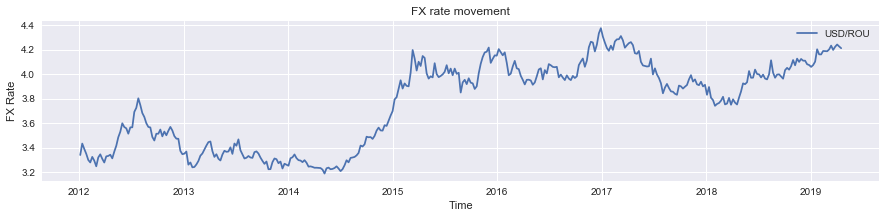

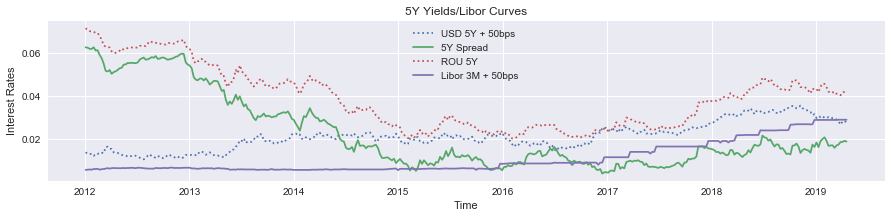

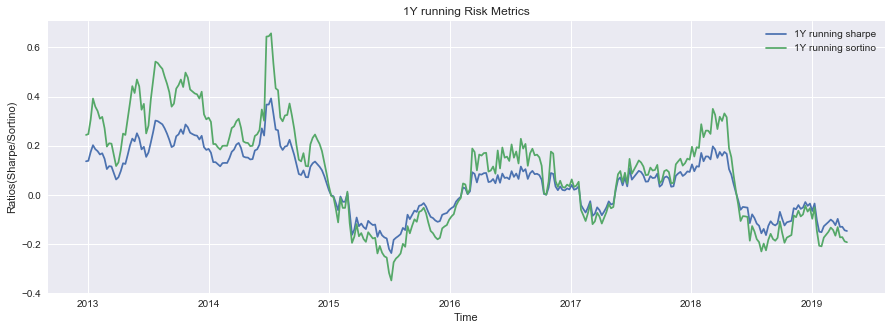

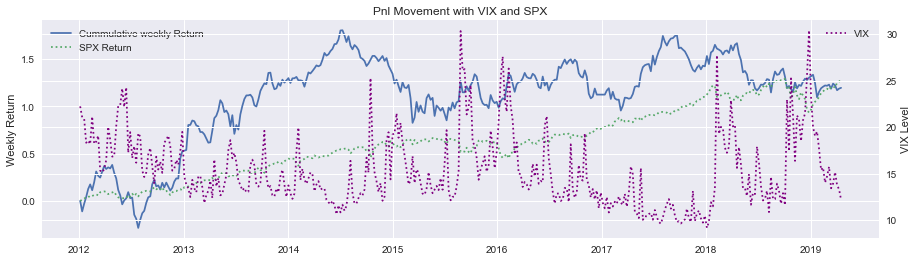

Correlation between Weekly Pnl and it's Components
       fx_pnl  Bond_Pnl_no_fx_change
Pnl  0.926167                0.50512 




In [12]:
carry_trade(cur="ROU")

##  Doing USD/IDN Carry Trade

###    Analysis

    1. The overall PNL is +2.1M USD over 4+ years, majority of it was made during 2016-2018 when FX rates were more or less constant, and we made PNL on the Bond Price difference.

    2. Return Distribution : Although we see a high value of distribution around left of 0, but both mean and median >0 (greater distribution on the right than left). Here we see more extreem right returns than left. Slightly high Return Kurtosis = 3.7 (expected)

    3. Cummulative Pnl : Although we made an overall profit, there were times when FX dominated the PNL. During Mid 2015 and Last Quarter 2018  we saw sudden jumps in FX rates, thus causing losses. These sharp declines also caused us to take losses on the bond pnl as visible below.

    4. Yield Curves : The sudden spikes in FX rates are visible in the 5Y Spread as well.

    5. VIX and SPX: We see a -ve correlation during Q3-Q4 2015 and Q4 2018, when VIX spike and the trade started losing money.  
    6. Of all the four countries we see IDN Bond weekly PNL has the highest correlation with the weekly PNL.

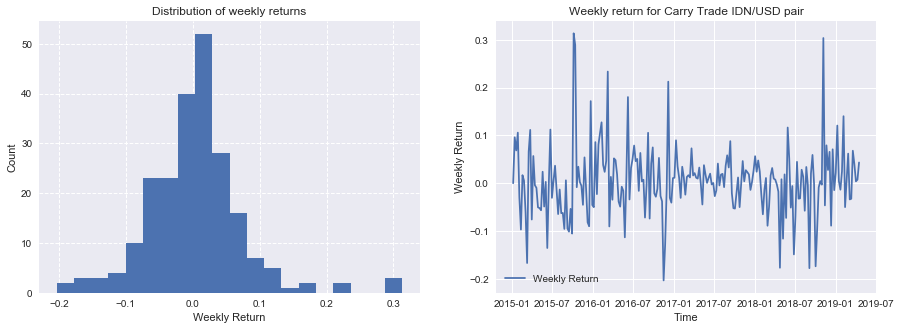



Return description :
count    224.000000
mean       0.004698
std        0.072785
min       -0.203355
25%       -0.032373
50%        0.004271
75%        0.035583
max        0.313487
Name: Return, dtype: float64
Return Kurtosis is :3.71 




<Figure size 1080x2520 with 0 Axes>

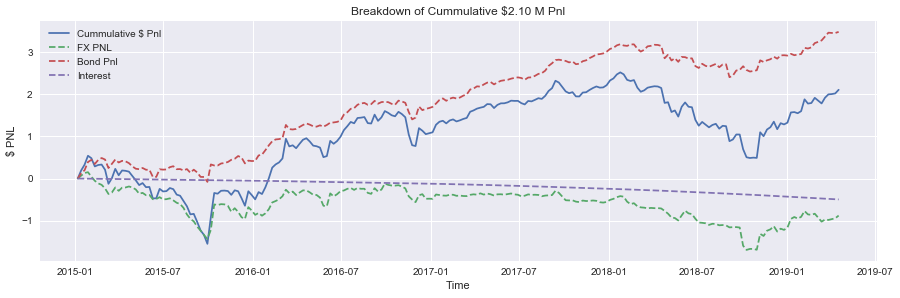

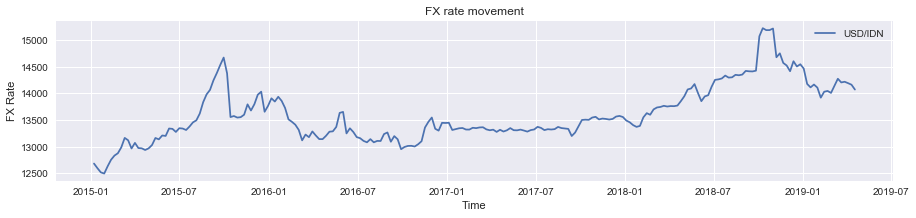

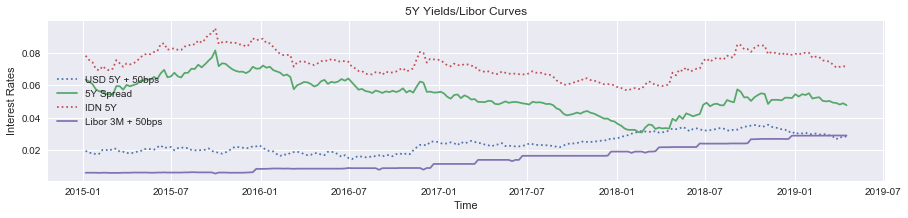

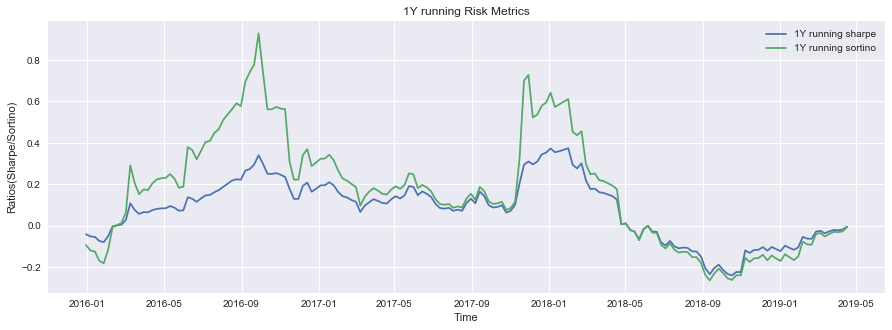

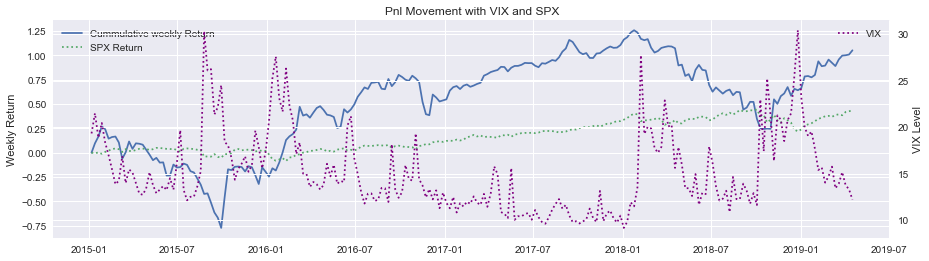

Correlation between Weekly Pnl and it's Components
       fx_pnl  Bond_Pnl_no_fx_change
Pnl  0.871779               0.833528 




In [13]:
carry_trade(cur="IDN")

##  Doing USD/CNH Carry Trade

###    Analysis

    1. The overall PNL is +0.3M USD over 4+ years, we see most of the times the FX PNL and Bond PNL cancelled each other out, thus we were unable to accumulate PNL.

    2. Return Distribution : we see a high value of distribution around 0, and median ~ 0. Here we see a fatter left tail than right. And Kurtosis =5.3, greater than for a normal distribution.

    3. Cummulative Pnl : The cummulative PNL looks like an inverted image of the FX curve, as mentioned above the Bond PNL and FX PNL more or less cancel each other out, hence no significant amount of PNL

    4. Yield Curves : We see the 5Y spread decreasing, due to Quantitative Easing in both countries. Towards the end of 2018 early 2019 we see Spread < 50 bps and would expect not a lot of trading to also take place.


    Given CNH is much more driven by the Government Policy than Markets, we should proceed with caution while doing any kind of trade based on the above analysis.

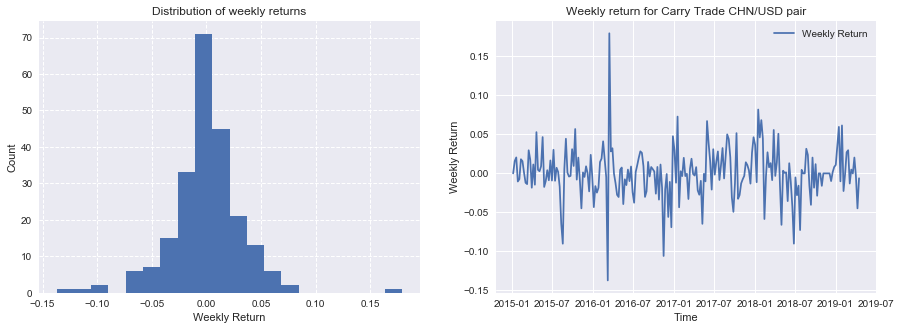



Return description :
count    224.000000
mean       0.000688
std        0.032604
min       -0.137108
25%       -0.013030
50%        0.000000
75%        0.016054
max        0.179477
Name: Return, dtype: float64
Return Kurtosis is :5.35 




<Figure size 1080x2520 with 0 Axes>

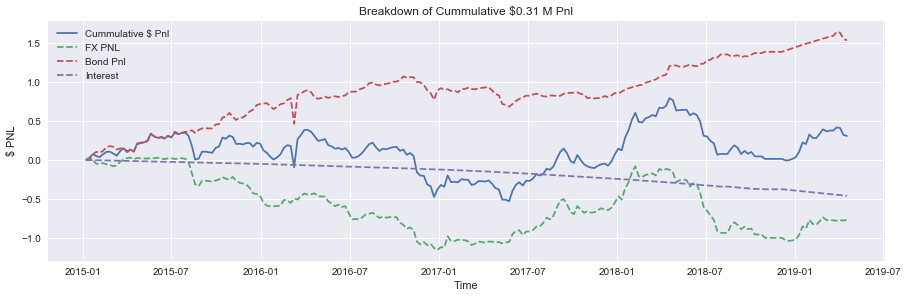

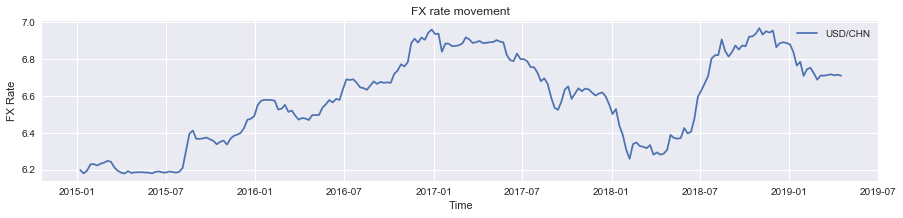

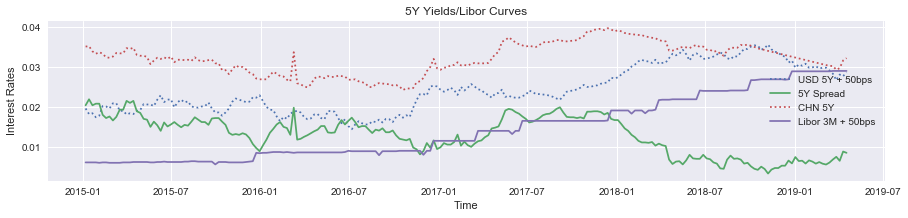

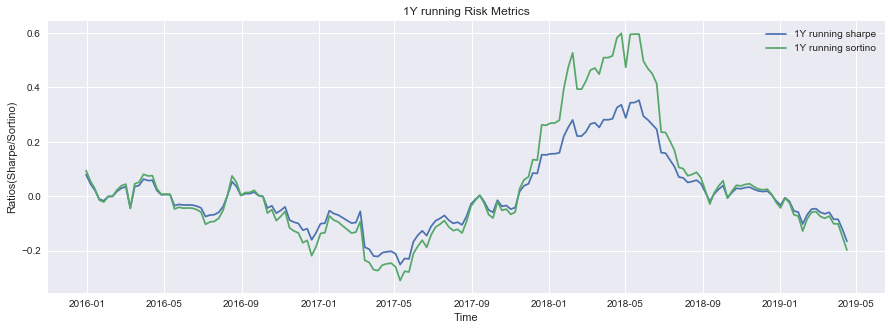

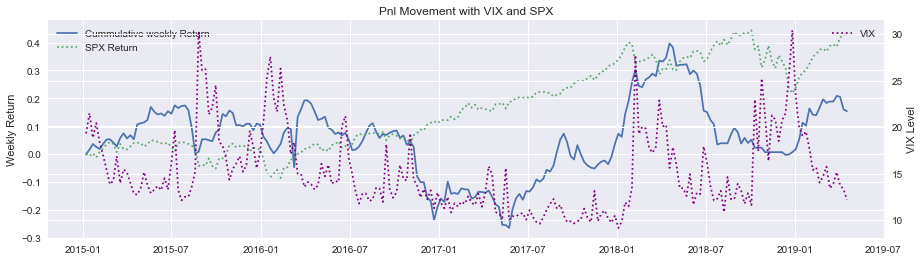

Correlation between Weekly Pnl and it's Components
      fx_pnl  Bond_Pnl_no_fx_change
Pnl  0.73594               0.669253 




In [14]:
carry_trade(cur="CHN")

# Summary:

##### 1. Distribution of Returns generally have more values to the right than left, fatter left tails and excess kurtosis.
##### 2. FX rates is one of the dominant factor in the overall PNL, especially given than the currencies we are lending in are Emerging Market there is greater FX risk. 
##### 3. The Lending Bond PNL generally is significant, until we see FX move against us and wipe it out. Thus one of the crucial element is market timing esp. for fx downside risk. Sudden movements in FX also impact the Bond PNL significantly.
##### 4. 5Y yield Spreads move in tandem with the FX rates. (There is a realtionship)
##### 5. Returns have a  -ve correlation to VIX index